### Dataset: Brazilian E-Commerce Public Dataset by Olist

Conjunto de dados públicos de comércio eletrônico brasileiro por Olist

Este é um conjunto de dados públicos de comércio eletrônico brasileiro de pedidos feitos na Olist Store. O conjunto de dados contém informações de 100 mil pedidos de 2016 a 2018 feitos em vários marketplaces no Brasil. Seus recursos permitem visualizar um pedido em múltiplas dimensões: desde status do pedido, preço, desempenho de pagamento e frete até localização do cliente, atributos do produto e finalmente avaliações escritas pelos clientes. Também um conjunto de dados de geolocalização que relaciona os CEPs brasileiros às coordenadas lat/lng.

Estes são dados comerciais reais, foram anonimizados e as referências às empresas e parceiros no texto da revisão foram substituídas pelos nomes das grandes casas de Game of Thrones.

Olist, a maior loja de departamentos dos mercados brasileiros. Olist conecta pequenas empresas de todo o Brasil a canais sem complicações e com um único contrato. Esses comerciantes podem vender seus produtos através da Olist Store e enviá-los diretamente aos clientes usando os parceiros logísticos da Olist. Veja mais em nosso site: www.olist.com

Depois que um cliente compra o produto na Olist Store, um vendedor é notificado para atender ao pedido. Assim que o cliente recebe o produto, ou vence a data estimada de entrega, o cliente recebe por e-mail uma pesquisa de satisfação onde pode dar uma nota da experiência de compra e anotar alguns comentários.
Atenção

Um pedido pode ter vários itens.
Cada item pode ser entregue por um vendedor distinto.
Todos os textos de identificação de lojas e parceiros foram substituídos pelos nomes das grandes casas de Game of Thrones.


PNL:

Este conjunto de dados oferece um ambiente supremo para analisar o texto das avaliações em suas múltiplas dimensões.

Agrupamento:

Alguns clientes não escreveram um comentário. Mas por que eles estão felizes ou bravos?

Previsão de vendas:

Com as informações da data de compra, você poderá prever vendas futuras.

Desempenho de entrega:

Você também poderá trabalhar o desempenho da entrega e encontrar maneiras de otimizar os prazos de entrega.

Qualidade do produto:

Divirta-se descobrindo as categorias de produtos mais propensas à insatisfação do cliente.

Engenharia de recursos:

Crie recursos a partir deste rico conjunto de dados ou anexe algumas informações públicas externas a ele.

# Importando bibliotecas

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import requests
from tqdm import tqdm
from sklearn.model_selection import (train_test_split as tst,
                                     RandomizedSearchCV as rcv)   
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import (MultinomialNB,
                                 GaussianNB)

from yellowbrick.classifier import (confusion_matrix,
                                    classification_report)
from sklearn import metrics
                               
import os

# NLP MODULES
import string
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import nltk
from spacy.lang.pt.stop_words import STOP_WORDS as pt_stop


from dotenv import (find_dotenv,
                    load_dotenv)

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
nlp=spacy.load("pt_core_news_md")
nltk.download('vader_lexicon')
nltk.download("punkt")
nltk.download("stopwords")
stop_words=nltk.corpus.stopwords.words('portuguese')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chenyenpin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chenyenpin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenyenpin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
to_include=['antes']

In [100]:
stop_words.append(to_include)

In [102]:

not_stop=["era","eram","éramos","esta","está","estamos","estão","estar",
          "estava","estavam","estávamos","esteja","estejam","estejamos","esteve","estive","estivemos",
          "estiver","estivera","estiveram","estivéramos","estiverem","estivermos","estivesse","estivessem",
          "estivéssemos","estou","foi" ,'fomos' ,'for',"foram"  ,"forem" ,"formos" ,"fosse" ,"fossem" ,"fôssemos",
          'há' ,'haja' ,'hajam' ,'hajamos','hão' ,'havemos' ,'haver','houve','não','teve' ,'tinha' ,'tinham' ,'tínhamos' ,
          'tive' ,'tivemos' ,'tiver' ,'tivera' ,'tiveram' ,'tiverem' ,'tivermos' ,'tivesse' ,'tivessem']
stop_words=[word for word in stop_words if not word in not_stop  ]

# Funcoes necessarias para desenvolvimento do trabalho

In [103]:
load_dotenv(find_dotenv())
path=os.getenv("path")


In [174]:
# Function to get the datas
def load_data(path:str, path1:str, path2:str)->pd.DataFrame:
    '''
    params:
    path:string
    return dataframe
    '''
    load_dotenv(find_dotenv())
    path=os.getenv("path")
    path1=os.getenv("path1") 
    path2=os.getenv("path2")
    df_rev=pd.read_csv(path)
    def_cust=pd.read_csv(path1)
    df_item=pd.read_csv(path2)
    return df_rev, def_cust, df_item

#--------------------------------------------------------------
# Eda Function
def eda(df:pd.DataFrame)->None:
  '''
  Retornara um analise exploratoria simples

  -param df: pandas dataframe
  '''
  print("-"*30,"DataFrame Shape", "-"*30)
  print(f"Columns {df.shape[0]}\nRows {df.shape[1]}")
  print("-"*30,"DataFrame info", "-"*30)
  print(df.info())
  print("-"*30,"DataFrame Nan", "-"*30)
  print(df.isna().sum())
  print("-"*30,"DataFrame duplicated", "-"*30)
  print(df.duplicated().sum())
  print("-"*30,"DataFrame nunique", "-"*30)
  print(df.nunique())
  
#---------------------------------------------------------------------

#Lower casing the words

def lower_case(column):
   '''
   Retorna as coluna selecionada para lower case
   '''
   return column.lower()

#---------------------------------------------------------
def remove_punctuation(column):
    '''
    Function to remove punctuation from the input string
    '''
    column = re.sub(f"[{re.escape(string.punctuation)}]", "", column)
    return column

#-------------------------------------------------------

def tokenize(columns:str)->pd.Series:
   tokenize= word_tokenize(columns)
   column_withno_stopwords=[token for token in tokenize  if not token in stop_words ]
   new_sentence=" ".join(column_withno_stopwords)
   return new_sentence


#------------------------------------------------------------

def seg(df: pd.DataFrame) -> pd.DataFrame:
  
    conditions = [
        (df['review_score'] < 3),
        (df['review_score'] >=3 )
    ]

    values = [1, 0]

    # Create a new column 'age_seg' based on the conditions
    df['sent'] = np.select(conditions, values, default=np.nan)

    return df
#-------------------------------------------------------------


def spacy_tokenizer(doc):
  '''
  Funcao que remove as pontuacoes, novas linhas lematiza nosso texto e apenas letras do alfabeto
  '''

  nlp=spacy.load("pt_core_news_md")
  return " ".join([t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            t.is_alpha])

#-----------------------------------------------------------------------

def metrics_evaluation(estimator, x_test, y_test):
    '''
    Função para calcular métricas de avaliação para um estimador dado.

    Parâmetros:
    estimator : objeto
        O modelo ou estimador treinado.
    x_test : array-like de forma (n_amostras, n_características)
        Amostras de teste.
    y_test : array-like de forma (n_amostras,)
        Rótulos verdadeiros para `x_test`.

    Retorna:
    dict
    Um dicionário contendo várias métricas de avaliação:
    - 'accuracy': Pontuação de acurácia do modelo.
    - 'balanced_accuracy': Pontuação de acurácia balanceada do modelo.
    - 'precision': Pontuação de precisão do modelo.
    - 'recall': Pontuação de recall do modelo.
    - 'f1': Pontuação F1 do modelo.
    - 'roc-auc' (se aplicável): Pontuação ROC-AUC do modelo. (Se o estimador tiver o método `predict_proba`)
    '''
    y_pred=estimator.predict(x_test)
    model_metrics = {
        'accuracy': metrics.accuracy_score(y_test, y_pred),
        'balanced_accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
        'precision': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'f1': metrics.f1_score(y_test, y_pred),
    }

    try:
      y_pred_proba = estimator.predict_proba(x_test)[:,1]
      model_metrics['roc-auc'] = metrics.roc_auc_score(y_test, y_pred_proba)
      return model_metrics
    except:
      return model_metrics

In [105]:
df_rev=pd.read_csv("Dados/olist_order_reviews_dataset.csv")
df_item=pd.read_csv("/Users/chenyenpin/Documents/ADAPR6/Dados/olist_order_items_dataset.csv")

In [106]:
#df_rev, df_cust, df_item=load_data("path","path1","path2")
df_item=df_item[['order_id',
     'price', 'freight_value']]
df_rev=df_rev[['order_id', 'review_score',
       'review_comment_message', 'review_creation_date']]

df=pd.merge(df_rev, df_item, how="inner", on="order_id").copy()

df.dropna(inplace=True)

df=df.reset_index(drop=True)

In [113]:
df['review_comment_message'] = df['review_comment_message'].apply(lambda x :lower_case(x))
df["review_comment_message"]=df["review_comment_message"].apply(lambda x :remove_punctuation(x))
df["token"]=df["review_comment_message"].apply(lambda x: tokenize(x))

In [115]:
seg(df)

,order_id,review_score,review_comment_message,review_creation_date,price,freight_value,token,sent
0,658677c97b385a9be170737859d3511b,5,recebi bem antes do prazo estipulado,2017-04-21 00:00:00,179.99,42.85,recebi bem antes prazo estipulado,0.0
1,8e6bfb81e283fa7e4f11123a3fb894f1,5,parabéns lojas lannister adorei comprar pela i...,2018-03-01 00:00:00,1199.00,134.25,parabéns lojas lannister adorei comprar intern...,0.0
2,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente no site a marca do aparelho...,2018-05-22 00:00:00,586.56,26.69,aparelho eficiente site marca aparelho esta im...,0.0
3,9d6f15f95d01e79bd1349cc208361f09,4,mas um pouco travandopelo valor ta boa\n,2018-02-16 00:00:00,35.00,7.78,pouco travandopelo valor ta boa,0.0
4,e51478e7e277a83743b6f9991dbfa3fb,5,vendedor confiável produto ok e entrega antes ...,2018-05-23 00:00:00,89.99,13.07,vendedor confiável produto ok entrega antes prazo,0.0
...,...,...,...,...,...,...,...,...
47637,d398e9c82363c12527f71801bf0e6100,4,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00,55.00,21.19,produto recebi acordo compra realizada,0.0
47638,509b86c65fe4e2ad5b96408cfef9755e,5,entregou dentro do prazo o produto chegou em c...,2018-02-07 00:00:00,160.00,8.71,entregou dentro prazo produto chegou condições...,0.0
47639,d5cb12269711bd1eaf7eed8fd32a7c95,3,o produto não foi enviado com nf não existe ve...,2018-05-19 00:00:00,29.99,12.79,produto não foi enviado nf não existe venda nf...,0.0
47640,55d4004744368f5571d1f590031933e4,5,excelente mochila entrega super rápida super r...,2018-03-22 00:00:00,215.97,15.59,excelente mochila entrega super rápida super r...,0.0


In [116]:
df[:2]

,order_id,review_score,review_comment_message,review_creation_date,price,freight_value,token,sent
0,658677c97b385a9be170737859d3511b,5,recebi bem antes do prazo estipulado,2017-04-21 00:00:00,179.99,42.85,recebi bem antes prazo estipulado,0.0
1,8e6bfb81e283fa7e4f11123a3fb894f1,5,parabéns lojas lannister adorei comprar pela i...,2018-03-01 00:00:00,1199.00,134.25,parabéns lojas lannister adorei comprar intern...,0.0


In [117]:
eda(df)

------------------------------ DataFrame Shape ------------------------------
Columns 47642
Rows 8
------------------------------ DataFrame info ------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47642 entries, 0 to 47641
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                47642 non-null  object 
 1   review_score            47642 non-null  int64  
 2   review_comment_message  47642 non-null  object 
 3   review_creation_date    47642 non-null  object 
 4   price                   47642 non-null  float64
 5   freight_value           47642 non-null  float64
 6   token                   47642 non-null  object 
 7   sent                    47642 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 2.9+ MB
None
------------------------------ DataFrame Nan ------------------------------
order_id                  0
review_score   

In [130]:
df[df.duplicated(keep="first")]

,order_id,review_score,review_comment_message,review_creation_date,price,freight_value,token,sent
19,3c314f50bc654f3c4e317b055681dff9,1,nada de chegar o meu pedido,2017-04-21 00:00:00,59.00,31.70,nada chegar pedido,1.0
30,32638fbca8d1a197e649fd5138e12049,5,ocorreu tudo como contratado sendo a entrega r...,2017-06-02 00:00:00,93.50,59.28,ocorreu tudo contratado sendo entrega realizad...,0.0
34,25362fbf6aac4b01a28dee1e076acc26,5,recomendo o vendedor,2018-08-17 00:00:00,39.90,16.47,recomendo vendedor,0.0
38,071251fe3b3493294536f03737a8a679,3,eu comprei duas unidades e só recebi uma e ago...,2017-11-09 00:00:00,12.49,15.10,comprei duas unidades recebi agora faço,0.0
43,17b296b73ebefd6213299342b09f097f,5,maravilha,2017-08-09 00:00:00,34.90,12.48,maravilha,0.0
...,...,...,...,...,...,...,...,...
47629,b7467ae483dbe956fe9acdf0b1e6e3f4,3,bom dia \ndas 6 unidades compradas só recebi 4...,2018-06-05 00:00:00,105.00,11.62,bom dia 6 unidades compradas recebi 4 unidades...,0.0
47630,b7467ae483dbe956fe9acdf0b1e6e3f4,3,bom dia \ndas 6 unidades compradas só recebi 4...,2018-06-05 00:00:00,105.00,11.62,bom dia 6 unidades compradas recebi 4 unidades...,0.0
47631,b7467ae483dbe956fe9acdf0b1e6e3f4,3,bom dia \ndas 6 unidades compradas só recebi 4...,2018-06-05 00:00:00,105.00,11.62,bom dia 6 unidades compradas recebi 4 unidades...,0.0
47632,b7467ae483dbe956fe9acdf0b1e6e3f4,3,bom dia \ndas 6 unidades compradas só recebi 4...,2018-06-05 00:00:00,105.00,11.62,bom dia 6 unidades compradas recebi 4 unidades...,0.0


In [132]:
df.drop_duplicates(keep="first", inplace=True)

In [133]:
df.shape

(42117, 8)

In [135]:
df["review_score"].value_counts(normalize=True)

review_score
5    0.496759
1    0.214426
4    0.145404
3    0.088610
2    0.054800
Name: proportion, dtype: float64

In [136]:
df.columns

Index(['order_id', 'review_score', 'review_comment_message',
       'review_creation_date', 'price', 'freight_value', 'token', 'sent'],
      dtype='object')

In [147]:
score_price=(df.groupby("review_score")
 .agg(mean_freight=("freight_value","mean"),
                               mean_price=('price','mean'))
                               .reset_index()
                               .sort_values(by="mean_price", ascending=False))

<Axes: xlabel='review_score', ylabel='mean_price'>

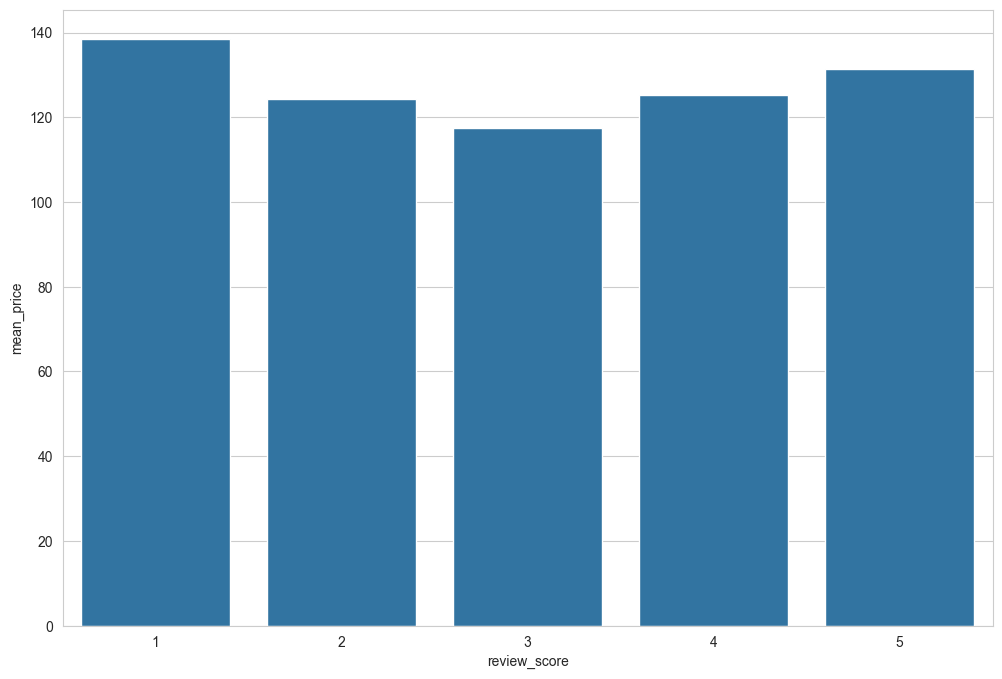

In [150]:
plt.figure(figsize=(12,8))
sns.barplot(data=score_price, x='review_score', y='mean_price');

# Treinamento

In [155]:
df_final=df[["token","sent"]]

In [166]:
teste=df_final[:2000]

In [168]:
X_train, X_test, y_train, y_test=tst(teste["token"], teste["sent"],
                                      random_state=101, stratify=teste["sent"], test_size=0.25)

In [170]:
pipe=Pipeline([
    ('preprocess', TfidfVectorizer(tokenizer=spacy_tokenizer)),
    ('model', LinearSVC(random_state=101))
    ])
pipe

Pipeline(steps=[('preprocess',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7fa4d341fb80>)),
                ('model', LinearSVC(random_state=101))])

In [171]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7fa4d341fb80>)),
                ('model', LinearSVC(random_state=101))])

In [172]:
pipe.predict(X_test)

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0.

In [175]:
metrics_evaluation(pipe, X_test, y_test)

{'accuracy': 0.8,
 'balanced_accuracy': 0.7066463723997971,
 'precision': 0.6732673267326733,
 'recall': 0.5037037037037037,
 'f1': 0.576271186440678}

In [ ]:
models={
    "dummy": DummyClassifier(i)
}